In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
import random
import numpy as np

In [36]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [37]:
SIZE_X = 320
SIZE_Y = 320

In [38]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [39]:
model = load_model('model_20240428.h5')

<h1>Code for segmenting and displaying one image</h1>

In [40]:
# Id of image that is to be segmented
IMAGE_ID = "0be45114544283beb4f6d371f946e889"

In [41]:
tested_image_1 = f'./segmentation/images_train/{IMAGE_ID}.png'
mask = f'./segmentation/masks_train/{IMAGE_ID}.png'

In [42]:
def segment_image(model, img_path):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
    img = np.array(img)

    img = np.expand_dims(img, axis=2)
    print(img.shape)
    img = normalize(img, axis=1)

    img_input=np.expand_dims(img, 0)
    print(img_input.shape)
    prediction=(model.predict(img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    
    return predicted_img

(320, 320, 1)
(1, 320, 320, 1)
1/1 [==============================] - 0s 126ms/step


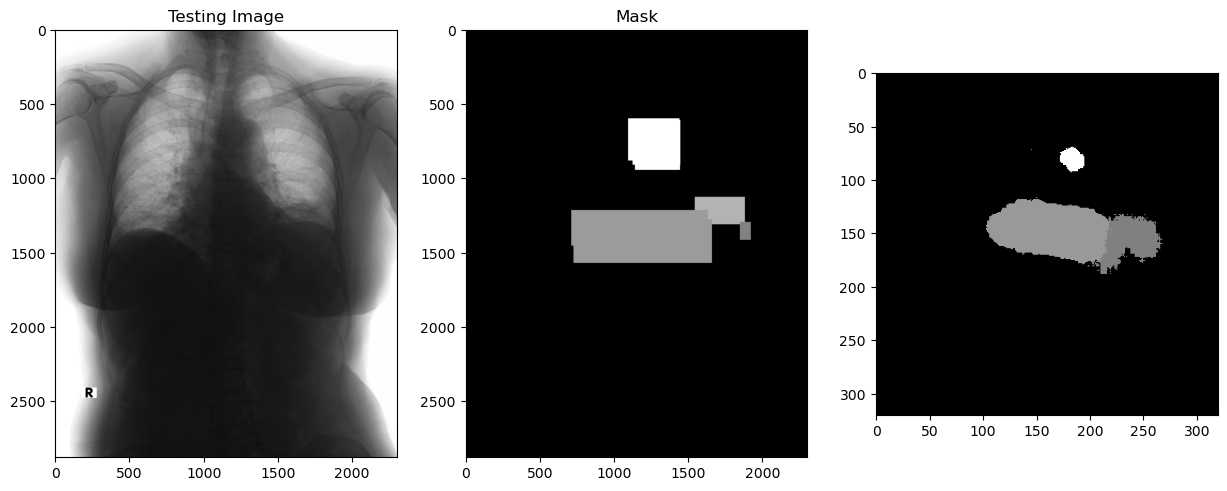

In [43]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(cv2.imread(tested_image_1, 0), cmap='gray')
plt.subplot(132)
plt.title('Mask')
plt.imshow(cv2.imread(mask, 0), cmap='gray')
plt.subplot(133)
plt.imshow(segment_image(model, tested_image_1), cmap='gray')

In [44]:
# unique pixel values in segmented mask

np.unique(segment_image(model, tested_image_1))

(320, 320, 1)
(1, 320, 320, 1)
1/1 [==============================] - 0s 51ms/step


array([ 0,  5,  6, 10])

In [45]:
# unique pixel values in true mask

np.unique(cv2.imread(mask, 0))

array([  0,  93, 111, 129, 183], dtype=uint8)

In [46]:
# to translate true and predicted classes

# 0: 0, 
# 21: 1, 
# 39: 2, 
# 57: 3, 
# 75: 4,
# 93: 5, 
# 111: 6, 
# 129: 7, 
# 147: 8, 
# 165: 9,
# 183: 10, 
# 201: 11, 
# 219: 12, 
# 237: 13, 
# 255: 14

<h1>Code for segmenting set of images</h1>

In [47]:
test_input_dir = "./segmentation/images_test"

In [48]:
def load_and_segment(model, input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Ensure the output directory exists
        
    class_to_grayscale = {
        0: 0, 1: 21, 2: 39, 3: 57, 4: 75,
        5: 93, 6: 111, 7: 129, 8: 147, 9: 165,
        10: 183, 11: 201, 12: 219, 13: 237, 14: 255
    }

    for filename in os.listdir(input_directory):
        full_path = os.path.join(input_directory, filename)
        image = cv2.imread(full_path, 0)  # Load image in grayscale
        
        if image is None:
            print(f"Failed to load image {filename}. Skipping...")
            continue  # Skip files that couldn't be read as images

        resized_image = cv2.resize(image, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
        img = np.array(resized_image)
        
        img = np.expand_dims(img, axis=2)
        img = normalize(img, axis=1)

        img_norm = img[:,:,0][:,:,None]
        img_input=np.expand_dims(img_norm, 0)
        prediction=(model.predict(img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        
        # map predicted classes back to grayscale values
        mapped_img = np.vectorize(class_to_grayscale.get)(predicted_img)

        output_path = os.path.join(output_directory, f"seg_{filename}")
        cv2.imwrite(output_path, mapped_img)  # Save the segmented image with grayscale values

    print(f"All segmented images have been saved to {output_directory}.")

In [49]:
output_directory = './segmentation/results1_test'

load_and_segment(model, test_input_dir, output_directory)

1/1 [==============================] - 0s 46ms/step
All segmented images have been saved to ./segmentation/results1_test.


In [50]:
# just to make sure something is in there

def unique_values(input_directory):
    unique_values_set = set()  # Use a set to store unique values
    for filename in os.listdir(input_directory):
        full_path = os.path.join(input_directory, filename)
        image = cv2.imread(full_path)
        if image is not None:  # Check if image is read properly
            unique = np.unique(image)
            unique_values_set.update(unique)  # Add unique values to the set
        else:
            print(f"Failed to read image {filename}")
    print(f"Unique classes: {', '.join(map(str, sorted(unique_values_set)))}")

In [51]:
unique_values(output_directory)

Unique classes: 0, 21, 39, 57, 75, 93, 111, 129, 183, 201
